<a href="https://colab.research.google.com/github/4GeeksAcademy/Jacinto-Clasficador-de-Imagenes/blob/main/Proyecto_redes_neuronales_perros_y_gatosipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os

from google.colab import drive
from glob import glob
from PIL import Image
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 1 - Carga de datos

En este paso montamos Google Drive para acceder al dataset y exploramos su estructura con el fin de confirmar que contiene las carpetas cats y dogs, organizadas correctamente por clases. Esto es esencial para usar flow_from_directory().

In [2]:
# Montamos google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Exploramos el contenido

ruta_base = "/content/drive/MyDrive/dataset"

def contar_jpg(ruta):
    return len([f for f in os.listdir(ruta) if f.lower().endswith('.jpg')]) if os.path.isdir(ruta) else 0

for root, dirs, files in os.walk(ruta_base):
    nivel = root.replace(ruta_base, '').count(os.sep)
    sangria = '  ' * nivel
    nombre_carpeta = os.path.basename(root)
    total_jpg = contar_jpg(root)
    print(f"{sangria}{nombre_carpeta}/ ({total_jpg} imágenes)")

dataset/ (0 imágenes)
  dogs_vs_cats/ (0 imágenes)
    test/ (0 imágenes)
      cats/ (2500 imágenes)
      dogs/ (2500 imágenes)
    train/ (0 imágenes)
      cats/ (10000 imágenes)
      dogs/ (10000 imágenes)
  test/ (0 imágenes)
    cats/ (2500 imágenes)
    dogs/ (2500 imágenes)
  train/ (0 imágenes)
    cats/ (10000 imágenes)
    dogs/ (10000 imágenes)


/content/drive/MyDrive/dataset/train/cats

/content/drive/MyDrive/dataset/train/dogs

## 2 - Preparar los generadores de imágenes

2.1 - Creamos los generadores de entrenamiento y validación a partir del directorio dataset/train.

- Aplicamos aumentos de datos al entrenamiento para mejorar la generalización.
- Reescalamos los valores de píxeles (rescale=1/255) para normalizar las imágenes.
- Definimos el tamaño de entrada: 128×128 píxeles.

In [4]:
ruta_train = "/content/drive/MyDrive/dataset/train"

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2
)

image_size = (128, 128)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    ruta_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    ruta_train,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


2.2 - Visualización de imagenes:

Verificamos visualmente que las imágenes estén bien cargadas desde el generador, que tienen el tamaño correcto, y que las etiquetas corresponden a su clase real (cats o dogs).


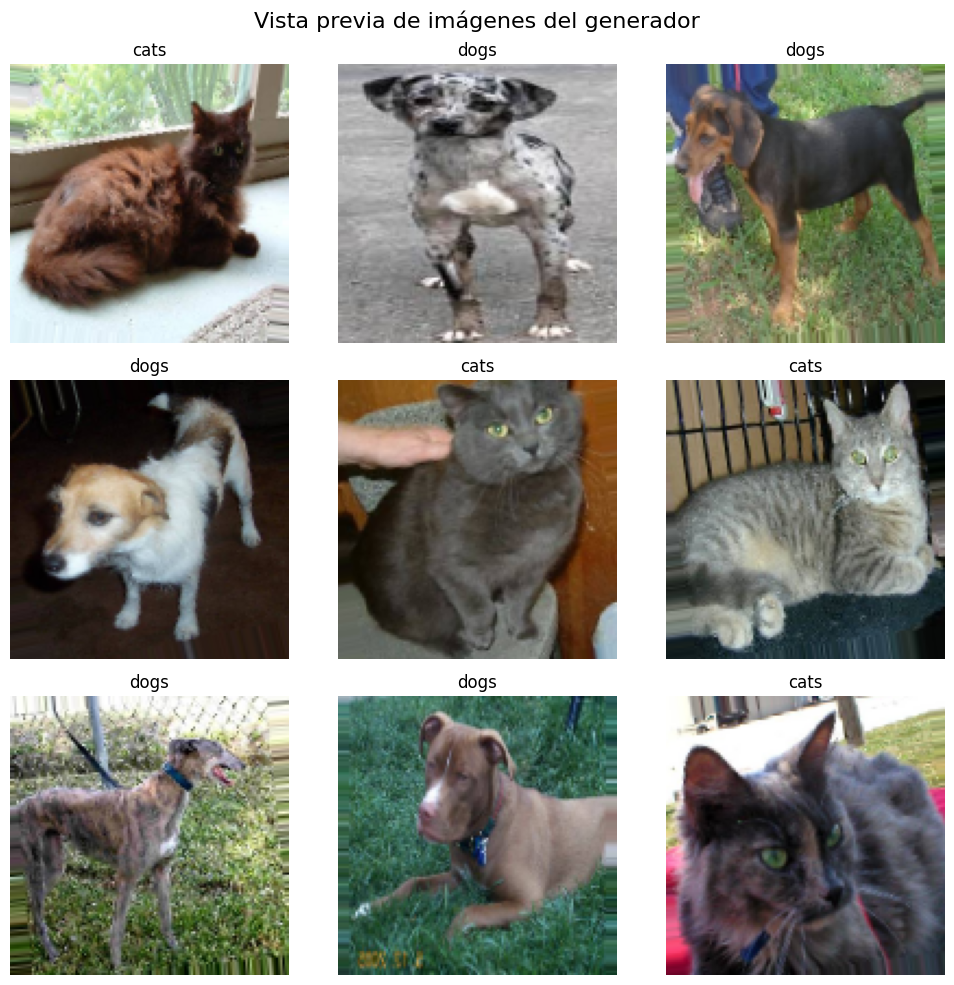

In [9]:
# Mostramos 9 imágenes de un batch del generador de entrenamiento
imagenes, etiquetas = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(imagenes[i])
    clase = etiquetas[i].argmax()
    nombre_clase = list(train_generator.class_indices.keys())[clase]
    plt.title(nombre_clase)
    plt.axis('off')

plt.suptitle("Vista previa de imágenes del generador", fontsize=16)
plt.tight_layout()
plt.show()

## 3 - Definición de la arquitectura del modelo

Creamos una CNN ligera y eficiente, con 3 bloques convolucionales y una capa densa final. Esta estructura tiene aproximadamente 1 millón de parámetros y es adecuada para entrenar en Colab con imágenes 128×128.

In [5]:
model = Sequential()
model.add(Input(shape=(128, 128, 3)))  # Tamaño de imagen

# Bloque 1
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Bloque 2
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Bloque 3
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))

# Clasificación final
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # Dos clases: cats y dogs

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,048,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,354 (4.09 MB)

 Trainable params: 1,072,354 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

## 4 – Compilar y entrenar el modelo

Usamos:

- categorical_crossentropy como función de pérdida porque hay 2 clases (gato y perro) y class_mode='categorical'.
- Adam con un learning rate bajo para una convergencia más estable.
- EarlyStopping para detener el entrenamiento si no hay mejoras.
- ModelCheckpoint para guardar el mejor modelo automáticamente.

In [6]:
# Compilamos el modelo
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Callbacks opcionales para mejor control del entrenamiento
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint("mejor_modelo.h5", save_best_only=True)
]

# Entrenamos el modelo
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5461 - loss: 0.6868

500/500 ━━━━━━━━━━━━━━━━━━━━ 4496s 9s/step - accuracy: 0.5461 - loss: 0.6868 - val_accuracy: 0.6625 - val_loss: 0.6171
Epoch 2/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.6613 - loss: 0.6198

500/500 ━━━━━━━━━━━━━━━━━━━━ 369s 738ms/step - accuracy: 0.6613 - loss: 0.6197 - val_accuracy: 0.7235 - val_loss: 0.5589
Epoch 3/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 678ms/step - accuracy: 0.6958 - loss: 0.5864

500/500 ━━━━━━━━━━━━━━━━━━━━ 380s 760ms/step - accuracy: 0.6958 - loss: 0.5864 - val_accuracy: 0.7405 - val_loss: 0.5394
Epoch 4/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 693ms/step - accuracy: 0.7152 - loss: 0.5566

500/500 ━━━━━━━━━━━━━━━━━━━━ 377s 752ms/step - accuracy: 0.7152 - loss: 0.5566 - val_accuracy: 0.7550 - val_loss: 0.5158
Epoch 5/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.7269 - loss: 0.5448

500/500 ━━━━━━━━━━━━━━━━━━━━ 373s 745ms/step - accuracy: 0.7269 - loss: 0.5448 - val_accuracy: 0.7573 - val_loss: 0.4984
Epoch 6/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.7400 - loss: 0.5218

500/500 ━━━━━━━━━━━━━━━━━━━━ 372s 744ms/step - accuracy: 0.7400 - loss: 0.5218 - val_accuracy: 0.7635 - val_loss: 0.4869
Epoch 7/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 683ms/step - accuracy: 0.7547 - loss: 0.5102

500/500 ━━━━━━━━━━━━━━━━━━━━ 370s 740ms/step - accuracy: 0.7547 - loss: 0.5102 - val_accuracy: 0.7605 - val_loss: 0.4817
Epoch 8/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - accuracy: 0.7608 - loss: 0.5018

500/500 ━━━━━━━━━━━━━━━━━━━━ 369s 738ms/step - accuracy: 0.7608 - loss: 0.5018 - val_accuracy: 0.7847 - val_loss: 0.4657
Epoch 9/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.7635 - loss: 0.4925

500/500 ━━━━━━━━━━━━━━━━━━━━ 376s 751ms/step - accuracy: 0.7636 - loss: 0.4924 - val_accuracy: 0.7805 - val_loss: 0.4536
Epoch 10/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7747 - loss: 0.4777

500/500 ━━━━━━━━━━━━━━━━━━━━ 370s 728ms/step - accuracy: 0.7747 - loss: 0.4777 - val_accuracy: 0.7868 - val_loss: 0.4453
Epoch 11/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.7805 - loss: 0.4692

500/500 ━━━━━━━━━━━━━━━━━━━━ 364s 728ms/step - accuracy: 0.7805 - loss: 0.4692 - val_accuracy: 0.7905 - val_loss: 0.4388
Epoch 12/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.7839 - loss: 0.4621

500/500 ━━━━━━━━━━━━━━━━━━━━ 366s 731ms/step - accuracy: 0.7839 - loss: 0.4621 - val_accuracy: 0.7968 - val_loss: 0.4279
Epoch 13/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 378s 756ms/step - accuracy: 0.7956 - loss: 0.4489 - val_accuracy: 0.7807 - val_loss: 0.4494
Epoch 14/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 673ms/step - accuracy: 0.8007 - loss: 0.4442

500/500 ━━━━━━━━━━━━━━━━━━━━ 369s 730ms/step - accuracy: 0.8007 - loss: 0.4442 - val_accuracy: 0.8073 - val_loss: 0.4174
Epoch 15/15
500/500 ━━━━━━━━━━━━━━━━━━━━ 366s 732ms/step - accuracy: 0.7989 - loss: 0.4391 - val_accuracy: 0.7970 - val_loss: 0.4348


## 5 – Visualizar el rendimiento del entrenamiento

Representamos gráficamente la evolución de la precisión y la pérdida en entrenamiento y validación. Estas gráficas nos permiten detectar:

- Mejora continua → el modelo está aprendiendo.
- Divergencia entre entrenamiento y validación → posible sobreajuste.
- Estancamiento → tal vez aumentar complejidad o entrenar más épocas.

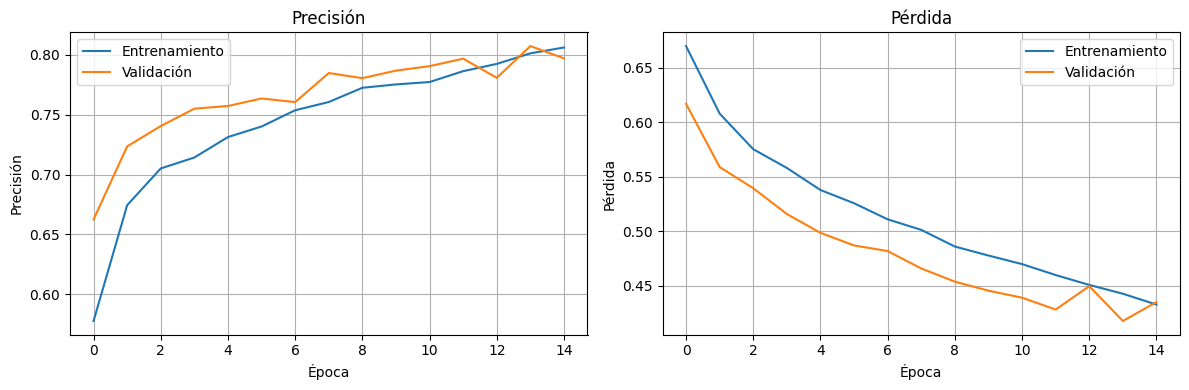

In [7]:
# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True)

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Análisis de las curvas de entrenamiento

Las gráficas muestran una evolución muy positiva del modelo:

- La precisión mejora de forma constante tanto en entrenamiento como en validación, y ambas curvas se mantienen muy cerca una de la otra, lo que indica bajo sobreajuste.
- La pérdida (loss) disminuye progresivamente en ambos conjuntos, con la de validación incluso siendo más baja que la de entrenamiento en varios momentos, lo cual es una señal de que el modelo generaliza bien.

Conclusión: el modelo ha aprendido a clasificar perros y gatos con solidez y estabilidad. La arquitectura ligera ha sido eficaz y el uso de EarlyStopping ha evitado sobreentrenamiento innecesario.

## 6 – Guardar el modelo entrenado

In [10]:
# Guardar el modelo entrenado en formato moderno de Keras
modelo_path = "/content/drive/MyDrive/perros_vs_gatos_v1.keras"
model.save(modelo_path)

print(f"Modelo guardado correctamente en:\n{modelo_path}")

Modelo guardado correctamente en:
/content/drive/MyDrive/perros_vs_gatos_v1.keras
